In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
os.makedirs("gan_samples", exist_ok=True)

In [3]:
def build_generator():
    model = tf.keras.Sequential(name="Generator")
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [4]:
def build_discriminator():
    model = tf.keras.Sequential(name="Discriminator")
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

In [5]:
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32")
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(256)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [6]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    return cross_entropy(tf.ones_like(real_output), real_output) + cross_entropy(tf.zeros_like(fake_output), fake_output)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator = build_generator()
discriminator = build_discriminator()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
EPOCHS = 30
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

gen_loss_list = []
disc_loss_list = []

In [8]:
@tf.function
def train_step(images):
    noise = tf.random.normal([256, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [9]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i, :, :, 0] + 1) / 2.0, cmap="gray")
        plt.axis("off")
    plt.savefig(f"gan_samples/epoch_{epoch:03d}.png")
    plt.close()

In [10]:
def train(dataset, epochs):
    print("Training started...")
    for epoch in range(1, epochs + 1):
        gen_loss_epoch = []
        disc_loss_epoch = []
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_epoch.append(gen_loss)
            disc_loss_epoch.append(disc_loss)

        mean_gen = np.mean(gen_loss_epoch)
        mean_disc = np.mean(disc_loss_epoch)
        gen_loss_list.append(mean_gen)
        disc_loss_list.append(mean_disc)

        print(f"Epoch {epoch}: Gen Loss = {mean_gen:.4f}, Disc Loss = {mean_disc:.4f}")
        generate_and_save_images(generator, epoch, seed)

In [14]:
train(train_dataset, EPOCHS)

Training started...
Epoch 1: Gen Loss = 1.0369, Disc Loss = 1.0688
Epoch 2: Gen Loss = 0.9322, Disc Loss = 1.1671
Epoch 3: Gen Loss = 0.9395, Disc Loss = 1.1911
Epoch 4: Gen Loss = 0.9057, Disc Loss = 1.2394
Epoch 5: Gen Loss = 0.8757, Disc Loss = 1.2642
Epoch 6: Gen Loss = 0.8736, Disc Loss = 1.2628
Epoch 7: Gen Loss = 0.8820, Disc Loss = 1.2445
Epoch 8: Gen Loss = 0.9194, Disc Loss = 1.2514
Epoch 9: Gen Loss = 1.0006, Disc Loss = 1.1736
Epoch 10: Gen Loss = 0.9915, Disc Loss = 1.1613
Epoch 11: Gen Loss = 1.0959, Disc Loss = 1.1426
Epoch 12: Gen Loss = 1.0861, Disc Loss = 1.1467
Epoch 13: Gen Loss = 1.1216, Disc Loss = 1.0594
Epoch 14: Gen Loss = 1.0958, Disc Loss = 1.1222
Epoch 15: Gen Loss = 1.1341, Disc Loss = 1.1008
Epoch 16: Gen Loss = 1.0972, Disc Loss = 1.1027
Epoch 17: Gen Loss = 1.2972, Disc Loss = 1.0224
Epoch 18: Gen Loss = 1.1893, Disc Loss = 1.0654
Epoch 19: Gen Loss = 1.1886, Disc Loss = 1.0471
Epoch 20: Gen Loss = 1.2818, Disc Loss = 1.0177
Epoch 21: Gen Loss = 1.2100, 

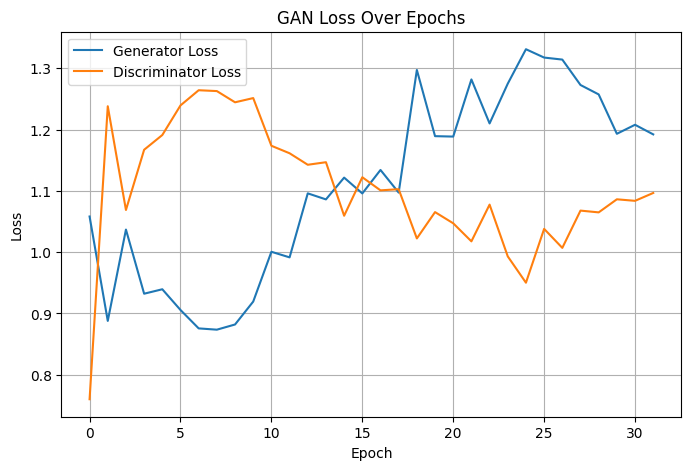

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(gen_loss_list, label="Generator Loss")
plt.plot(disc_loss_list, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GAN Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.savefig("loss_plot.png")
plt.show()